In [1]:
%matplotlib inline


Surface Transfer Learning
==========================

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
baseDirectory = 'f:/Datasets'
setDirectory = 'EBA5'
setImageSize = 224

# MSoS mean and std values
#0.544978628454
#0.0564096715989
setMean = [0.544, 0.544, 0.544]
setStd = [0.056, 0.056, 0.056]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )

{'train': 607, 'test': 311} images will be used.
GPU will be used.


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



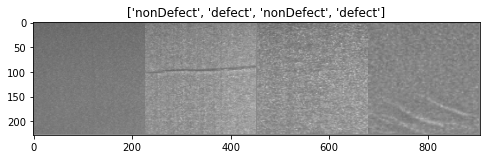

In [4]:
def ImShow(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    input = setStd * input + setMean
    plt.figure(figsize=(8,8))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
ImShow(out, title=[datasetClasses[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving (deep copying) the best model

In the following, parameter ``lr_scheduler(optimizer, epoch)``
is a function  which modifies ``optimizer`` so that the learning
rate is changed according to desired schedule.



In [5]:
def TrainModelMiniBatch(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in datasetLoaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if useGPU:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

Learning rate scheduler
^^^^^^^^^^^^^^^^^^^^^^^
Let's create our learning rate scheduler. We will exponentially
decrease the learning rate once every few epochs.



In [6]:
def ExpLRScheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [17]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(datasetLoaders['test']):
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(datasetClasses[labels.data[j]]))
            ImShow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if useGPU:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

if useGPU:
    criterion = criterion.cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = TrainModelMiniBatch(model_ft, criterion, optimizer_ft, ExpLRScheduler, num_epochs=10)  

Epoch 0/9
----------
LR is set to 0.001
train Loss: 0.1502 Acc: 0.7479
test Loss: 0.1367 Acc: 0.8489

Epoch 1/9
----------
train Loss: 0.0953 Acc: 0.8616
test Loss: 0.0558 Acc: 0.9132

Epoch 2/9
----------
train Loss: 0.0988 Acc: 0.8633
test Loss: 0.0279 Acc: 0.9453

Epoch 3/9
----------
train Loss: 0.1024 Acc: 0.8600
test Loss: 0.0177 Acc: 0.9775

Epoch 4/9
----------
train Loss: 0.0812 Acc: 0.8896
test Loss: 0.0053 Acc: 0.9936

Epoch 5/9
----------
train Loss: 0.0750 Acc: 0.8995
test Loss: 0.0270 Acc: 0.9614

Epoch 6/9
----------
train Loss: 0.0667 Acc: 0.9077
test Loss: 0.0196 Acc: 0.9775

Epoch 7/9
----------
LR is set to 0.0001
train Loss: 0.0437 Acc: 0.9440
test Loss: 0.0163 Acc: 0.9775

Epoch 8/9
----------
train Loss: 0.0361 Acc: 0.9539
test Loss: 0.0130 Acc: 0.9839

Epoch 9/9
----------
train Loss: 0.0418 Acc: 0.9522
test Loss: 0.0106 Acc: 0.9871

Training complete in 1m 16s
Best val Acc: 0.993569


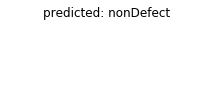

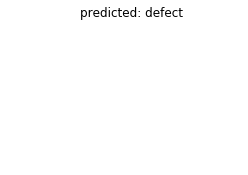

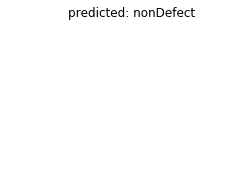

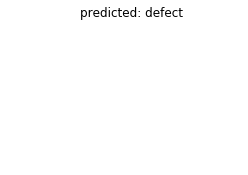

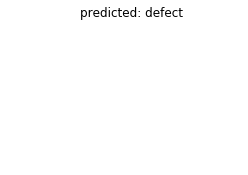

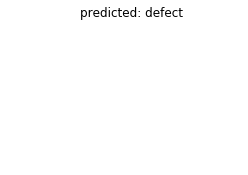

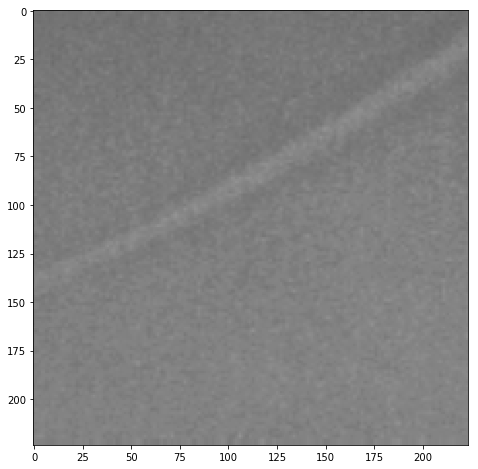

In [18]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [31]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
LR is set to 0.001
train Loss: 0.1930 Acc: 0.5420
test Loss: 0.1510 Acc: 0.6720

Epoch 1/9
----------
train Loss: 0.2100 Acc: 0.5750
test Loss: 0.2529 Acc: 0.6045

Epoch 2/9
----------
train Loss: 0.1883 Acc: 0.6079
test Loss: 0.1511 Acc: 0.7074

Epoch 3/9
----------
train Loss: 0.1974 Acc: 0.5997
test Loss: 0.1584 Acc: 0.6849

Epoch 4/9
----------
train Loss: 0.1640 Acc: 0.6623
test Loss: 0.1854 Acc: 0.6559

Epoch 5/9
----------
train Loss: 0.1840 Acc: 0.6293
test Loss: 0.1707 Acc: 0.6881

Epoch 6/9
----------
train Loss: 0.1754 Acc: 0.6474
test Loss: 0.2371 Acc: 0.6109

Epoch 7/9
----------
LR is set to 0.0001
train Loss: 0.1482 Acc: 0.6952
test Loss: 0.1485 Acc: 0.7138

Epoch 8/9
----------
train Loss: 0.1437 Acc: 0.7002
test Loss: 0.1583 Acc: 0.6913

Epoch 9/9
----------
train Loss: 0.1422 Acc: 0.7084
test Loss: 0.1535 Acc: 0.7042

Training complete in 0m 57s
Best val Acc: 0.713826


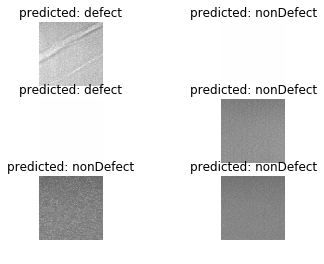

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [17]:
torch.save(model_ft, 'Resnet18_Surface.net')

In [18]:
rn18 = torch.load('Resnet18_Surface.net')

In [36]:
batch1In, batch1Labels = next(iter(dset_loaders['test']))
batch1In = Variable(batch1In.cuda())
batch1Labels = Variable(batch1Labels.cuda())
batch1Out = model_ft(batch1In)#rn18(batch1In)
_, batch1Preds = torch.max(batch1Out.data, 1)
print(batch1Preds)
print(batch1Labels)


 0
 0
 0
 1
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

Variable containing:
 0
 0
 0
 0
[torch.cuda.LongTensor of size 4 (GPU 0)]

